# 04 - EDA

In this notebook, we will explore the dataset extracted from the Defectors project:
- Understand distributions of numeric and categorical features
- Examine label balance and repo distributions
- Explore correlations and feature importance potential
- Inspect text fields, embeddings, and code-related metrics
- Detect outliers and anomalies

## 1.1 Set Up

### 1.1.1 Setting Up Logger

In [6]:
import ipynbname
import random
from logging_config import setup_logger

# Get notebook name
try:
    notebook_name = ipynbname.name()
except:
    notebook_name = "UNKNOWN_NOTEBOOK"

# Generate small session run ID
session_id = random.randint(100, 999)

# Create logger with session ID included
logger_name = f"{notebook_name}-S{session_id}"
logger = setup_logger(logger_name)

def log_check(text: str):
    logger.info(f"[EDA CHECK] {text}")

def log_result(text: str):
    logger.info(f"[EDA RESULT] {text}")
    
logger.info(f"================== Starting notebook: {notebook_name} (Session {session_id}) ==================")

## 1.1.2 Setting Up Root

In [7]:
logger.info("Setting up root by appending the parent to the sys...")
from jupyter_init import setup

setup()

from src_code.config import *

## 1.1.3 Loading Dataset

In [8]:
logger.info("Loading the dataset...")
import pandas as pd
import numpy as np
import seaborn as sns

# TRANSFORMED_DF = EXTRACTED_DATA_DIR / "train_labeled_features_partial.feather"
TRANSFORMED_DF = PREPROCESSED_DATA_DIR / "train_preprocessed.feather"

# ---- LOAD ----
df = pd.read_feather(TRANSFORMED_DF)
print(f"Loaded dataframe with {len(df)} rows and {len(df.columns)} columns\n")

# For large datasets
pd.set_option('display.max_columns', 50)
sns.set_theme(style="whitegrid", context="notebook", palette="muted")

Loaded dataframe with 125860 rows and 31 columns



## 1.2 EDA

In [9]:
logger.info("Starting the EDA process...")

### 1.2.1 General Overview

In [10]:
# log.info("[EDA CHECK] Checking the general overview...")
log_check("Checking the general overview...")
# print(f"Dataset shape: {df.shape}")
# log.info(f"[EDA RESULT] Dataset shape: {df.shape}")
log_result(f"Dataset shape: {df.shape}")

# First few rows
df.head()

# Column types
df_dtypes = df.dtypes
# Convert dtypes to list of tuples
dtypes_list = [(col, str(dtype)) for col, dtype in df.dtypes.items()]

# Log it
# log.info(f"[EDA RESULT] Dtypes: {dtypes_list}")
log_result(f"Dtypes: {dtypes_list}")

df_dtypes, df.head()

(datetime                      datetime64[us, pytz.FixedOffset(-120)]
 commit                                                        object
 repo                                                          object
 filepath                                                      object
 content                                                       object
 methods                                                       object
 lines                                                         object
 author_email                                                  object
 canonical_datetime                               datetime64[ns, UTC]
 author_exp_pre                                               float64
 author_recent_activity_pre                                   float64
 label                                                          int64
 loc_added                                                    float64
 loc_deleted                                                  float64
 files_changed      

## Missing Values

In [11]:
# log.info("[EDA CHECK] Checking missing values...") 
log_check("Checking missing values...")

# Check missing values
missing = df.isnull().sum()
missing_nonzero = missing[missing > 0]

# Convert to list of tuples for compact logging
missing_list = [(col, int(count)) for col, count in missing_nonzero.items()]

# Log
# log.info(f"[EDA RESULT] Missing values (only non-zero): {missing_list}")
log_result("Missing values (only non-zero): {missing_list}")

## Label Distribution

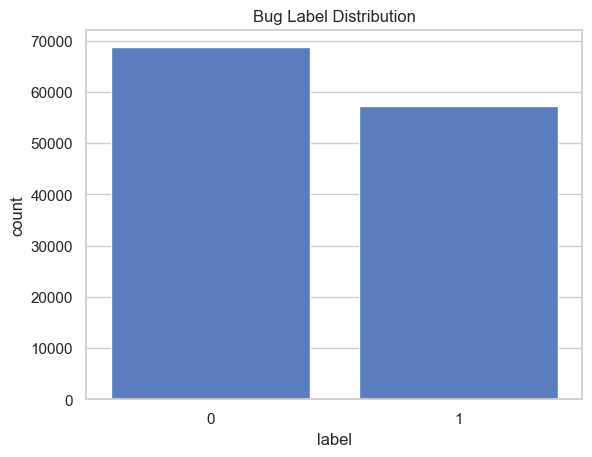

In [12]:
log_check("Checking Label Distribution...")
from matplotlib import pyplot as plt

# Plot
sns.countplot(x='label', data=df)
plt.title("Bug Label Distribution")
plt.show()

# Raw counts
label_counts = df["label"].value_counts()
log_result(f"Label counts: {[(int(k), int(v)) for k, v in label_counts.items()]}")

# Proportions
label_props = df["label"].value_counts(normalize=True)
log_result(f"Label proportions: {[(int(k), round(float(v), 4)) for k, v in label_props.items()]}")

## Repository Distribution

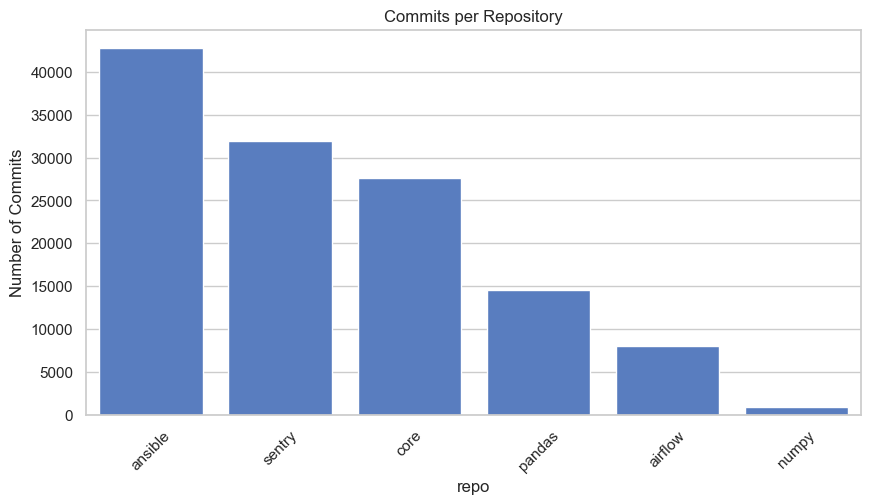

In [13]:
# %% 
log_check("Checking commits per repository...")

repo_counts = df['repo'].value_counts()

# Plot
plt.figure(figsize=(10,5))
sns.barplot(x=repo_counts.index, y=repo_counts.values)
plt.title("Commits per Repository")
plt.ylabel("Number of Commits")
plt.xticks(rotation=45)
plt.show()

# Raw counts (one-line log)
log_result(
    f"Repo commit counts: {[(repo, int(count)) for repo, count in repo_counts.items()]}"
)

# Proportions (one-line log)
repo_props = repo_counts / len(df)
log_result(
    f"Repo commit proportions: {[(repo, round(float(prop), 4)) for repo, prop in repo_props.items()]}"
)

## Numeric Features with Negative Value

In [14]:
log_check("Checking negative numeric features...")
from notebooks.constants import NUMERIC_FEATURES

negatives = []

for col in NUMERIC_FEATURES:
    # Calculate the total number of rows (non-NaN count) in the column
    total_count = df[col].count()

    # Calculate the number of negative values in the column
    negative_count = (df[col] < 0).sum()

    # Calculate the proportion of negative values
    if total_count > 0:
        proportion = negative_count / total_count
    else:
        proportion = 0  # Handle case where the column is entirely NaN or empty

    if proportion:
        log_result(
            f"Negative Feature: **{col}** - Count of negative values: {negative_count} - Proportion of negative values: **{proportion:.4f}"
        )
        # log_result(f"Total entries (non-NaN): {total_count}")
        # log_result(f"Count of negative values: {negative_count}")
        # log_result(f"Proportion of negative values: **{proportion:.4f}**")

# log_result(f"Found following negative features: {negatives}")

for negative in negatives:
    print(df[negative].describe())

negatives

[]

## 5. Numeric Feature Distributions

Examine numeric columns such as `loc_added`, `loc_deleted`, `hunks_count`, `max_func_change`, etc.

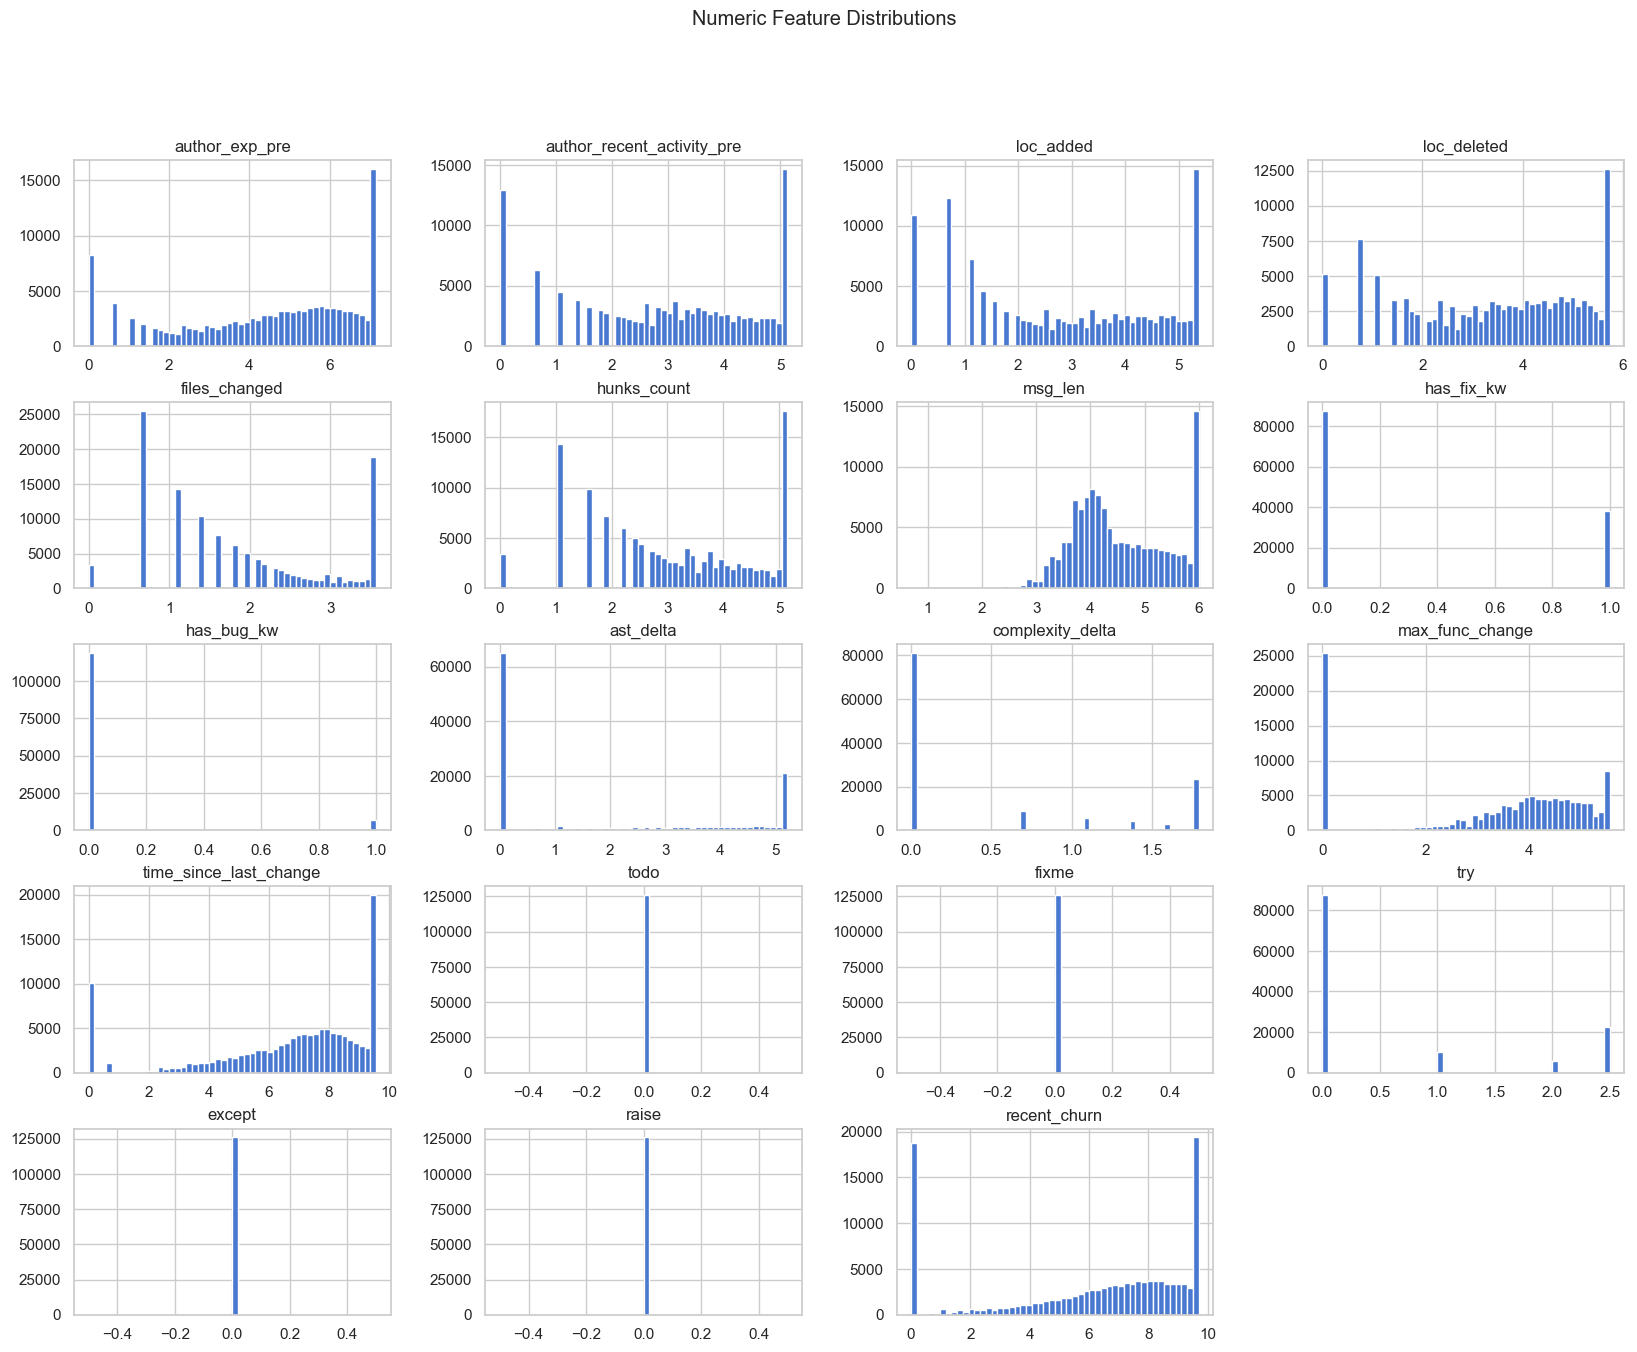

In [15]:
# %%
import scipy.stats as stats

log_check("Checking Numeric Feature Distribution Shape (NAME, SKEW, KURT, MEAN, STD)...")
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('label')  # exclude target

summary = []

for col in num_cols:
    skew = round(stats.skew(df[col].dropna()), 3)
    kurt = round(stats.kurtosis(df[col].dropna()), 3)
    mean = round(df[col].mean(), 3)
    std = round(df[col].std(), 3)

    summary.append((col, skew, kurt, mean, std))

# Log as single line
log_result(f"Numeric distributions summary: {summary}")

# Optional: still show hist plots for visual inspection
df[num_cols].hist(bins=50, figsize=(20, 15))
plt.suptitle("Numeric Feature Distributions")
plt.show()

### Log-transformed histograms for skewed metrics

In [16]:
# %% 

if TRANSFORMED_DF.parent == EXTRACTED_DATA_DIR:
    log_check("Checking log-transformed skewed cols, output format - (NAME, SKEW, KURT, MEAN, STD)...")

    skewed_cols = ['loc_added', 'loc_deleted', 'files_changed', 'hunks_count', 
                'ast_delta', 'complexity_delta', 'max_func_change', 'recent_churn',
                'author_exp_pre', 'author_recent_activity_pre', 'msg_len']

    plt.figure(figsize=(20,15))
    for i, col in enumerate(skewed_cols, 1):
        col_log = np.log1p(df[col].dropna())

        plt.subplot(6,2,i)
        # sns.histplot(np.log1p(df[col]), bins=50, kde=True)
        sns.histplot(col_log, bins=50, kde=True)
        plt.title(f"log1p({col}) distribution")
        log_result(
            f"{col}_log1p: skew={col_log.skew():.3f}, "
            f"kurt={col_log.kurtosis():.3f}, "
            f"mean={col_log.mean():.3f}, std={col_log.std():.3f}"
        )
    plt.tight_layout()
    plt.show()
elif TRANSFORMED_DF.parent == PREPROCESSED_DATA_DIR:
    log_check("The loaded dataset has already been preprocessed - skipping log-transformation.")
else:
    err_msg = "Unknown parent of the input dataset!"
    logger.error(err_msg)
    raise ValueError(err_msg)

## Correlations
Examine correlations between numeric features and label

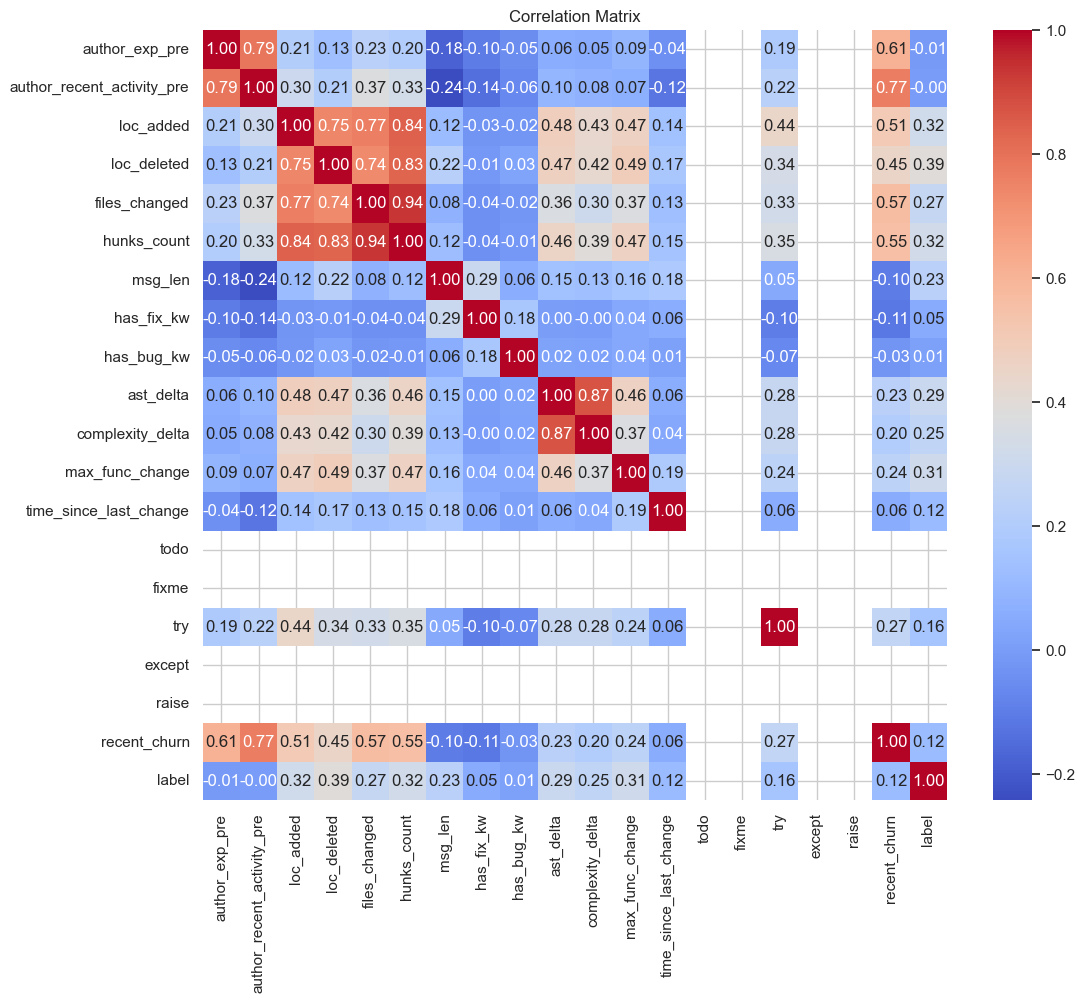

Correlations with label
label                         1.000000
loc_deleted                   0.392833
hunks_count                   0.324829
loc_added                     0.317432
max_func_change               0.313336
ast_delta                     0.294274
files_changed                 0.274795
complexity_delta              0.254712
msg_len                       0.233332
try                           0.157018
recent_churn                  0.118575
time_since_last_change        0.116787
has_fix_kw                    0.049572
has_bug_kw                    0.011168
author_recent_activity_pre   -0.002938
author_exp_pre               -0.007388
todo                               NaN
fixme                              NaN
except                             NaN
raise                              NaN
Name: label, dtype: float64


In [17]:
# %%
log_check("Computing correlation matrix...")

corr_matrix = df[num_cols + ['label']].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

print("Correlations with label")
print("===========")
# Correlation with label
corr_with_label = corr_matrix['label'].sort_values(ascending=False)
print(corr_with_label)

# Log correlations for each feature on separate line
log_check("Logging correlations for each feature...")

for feature in corr_matrix.columns:
    # Create a compact list of (other_feature, corr)
    correlations = [
        (other, float(corr_matrix.at[feature, other]))
        for other in corr_matrix.columns
        if other != feature
    ]

    log_result(f"{feature}: {correlations}")

## Categorical Features and File Types

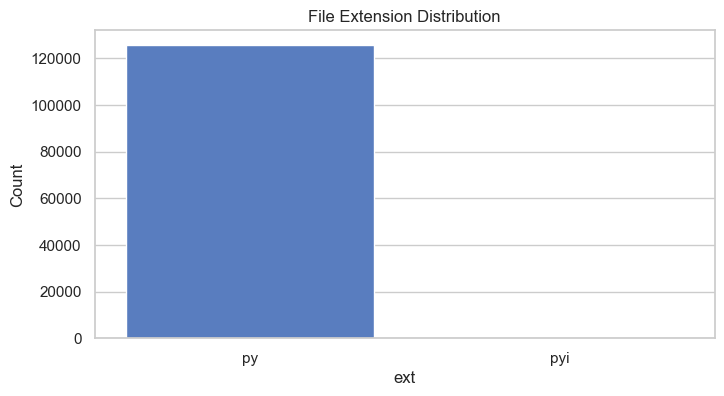

In [18]:
# %%
log_check("Checking File Extension Distribution...")

# Compute extensions
df['ext'] = df['filepath'].str.split('.').str[-1]

# Counts
ext_counts = df['ext'].value_counts()
log_result(f"Extension counts: {ext_counts.to_dict()}")

# Proportions
ext_props = (ext_counts / len(df)).round(4)
log_result(f"Extension proportions: {ext_props.to_dict()}")

# Plot
plt.figure(figsize=(8,4))
sns.barplot(x=ext_counts.index, y=ext_counts.values)
plt.title("File Extension Distribution")
plt.ylabel("Count")
plt.show()

## Commit Message and Code Text Analysis

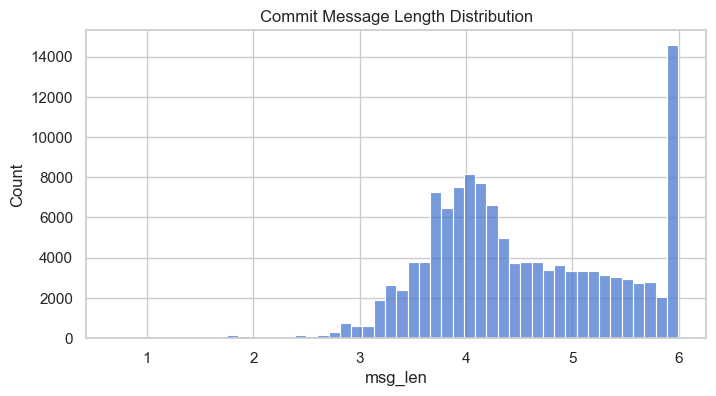

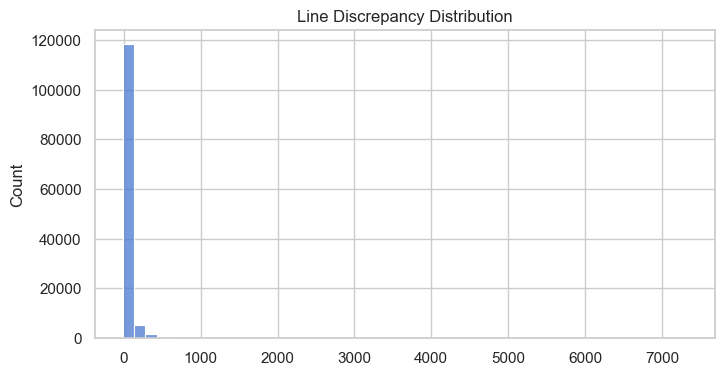

In [19]:
# %%
log_check("Checking Commit Message Length Distribution...")

# --- Commit message lengths ---
msg_stats = df['msg_len'].describe().to_dict()
log_result(f"msg_len stats: {msg_stats}")

plt.figure(figsize=(8,4))
sns.histplot(df['msg_len'], bins=50)
plt.title("Commit Message Length Distribution")
plt.show()


# --- Empty content rows ---
empty_content = int((df['content'].str.len() == 0).sum())
log_result(f"Empty content rows: {empty_content}")


# --- Line discrepancy analysis ---
log_check("Checking line count discrepancy (content_lines - loc_added - loc_deleted)...")

line_discrepancy = df["content"].str.count("\n") - df["loc_added"] - df["loc_deleted"]
disc_stats = line_discrepancy.describe().to_dict()

# Convert numpy values to python floats
disc_stats = {k: float(v) for k, v in disc_stats.items()}

log_result(f"line_discrepancy stats: {disc_stats}")

# Optional plot (not logged)
plt.figure(figsize=(8,4))
sns.histplot(line_discrepancy, bins=50)
plt.title("Line Discrepancy Distribution")
plt.show()

Very short messages may need normalization.

## Outliers


### Detection
Detect extreme values in `time_since_last_change`, `recent_churn`, `loc_added`, etc.

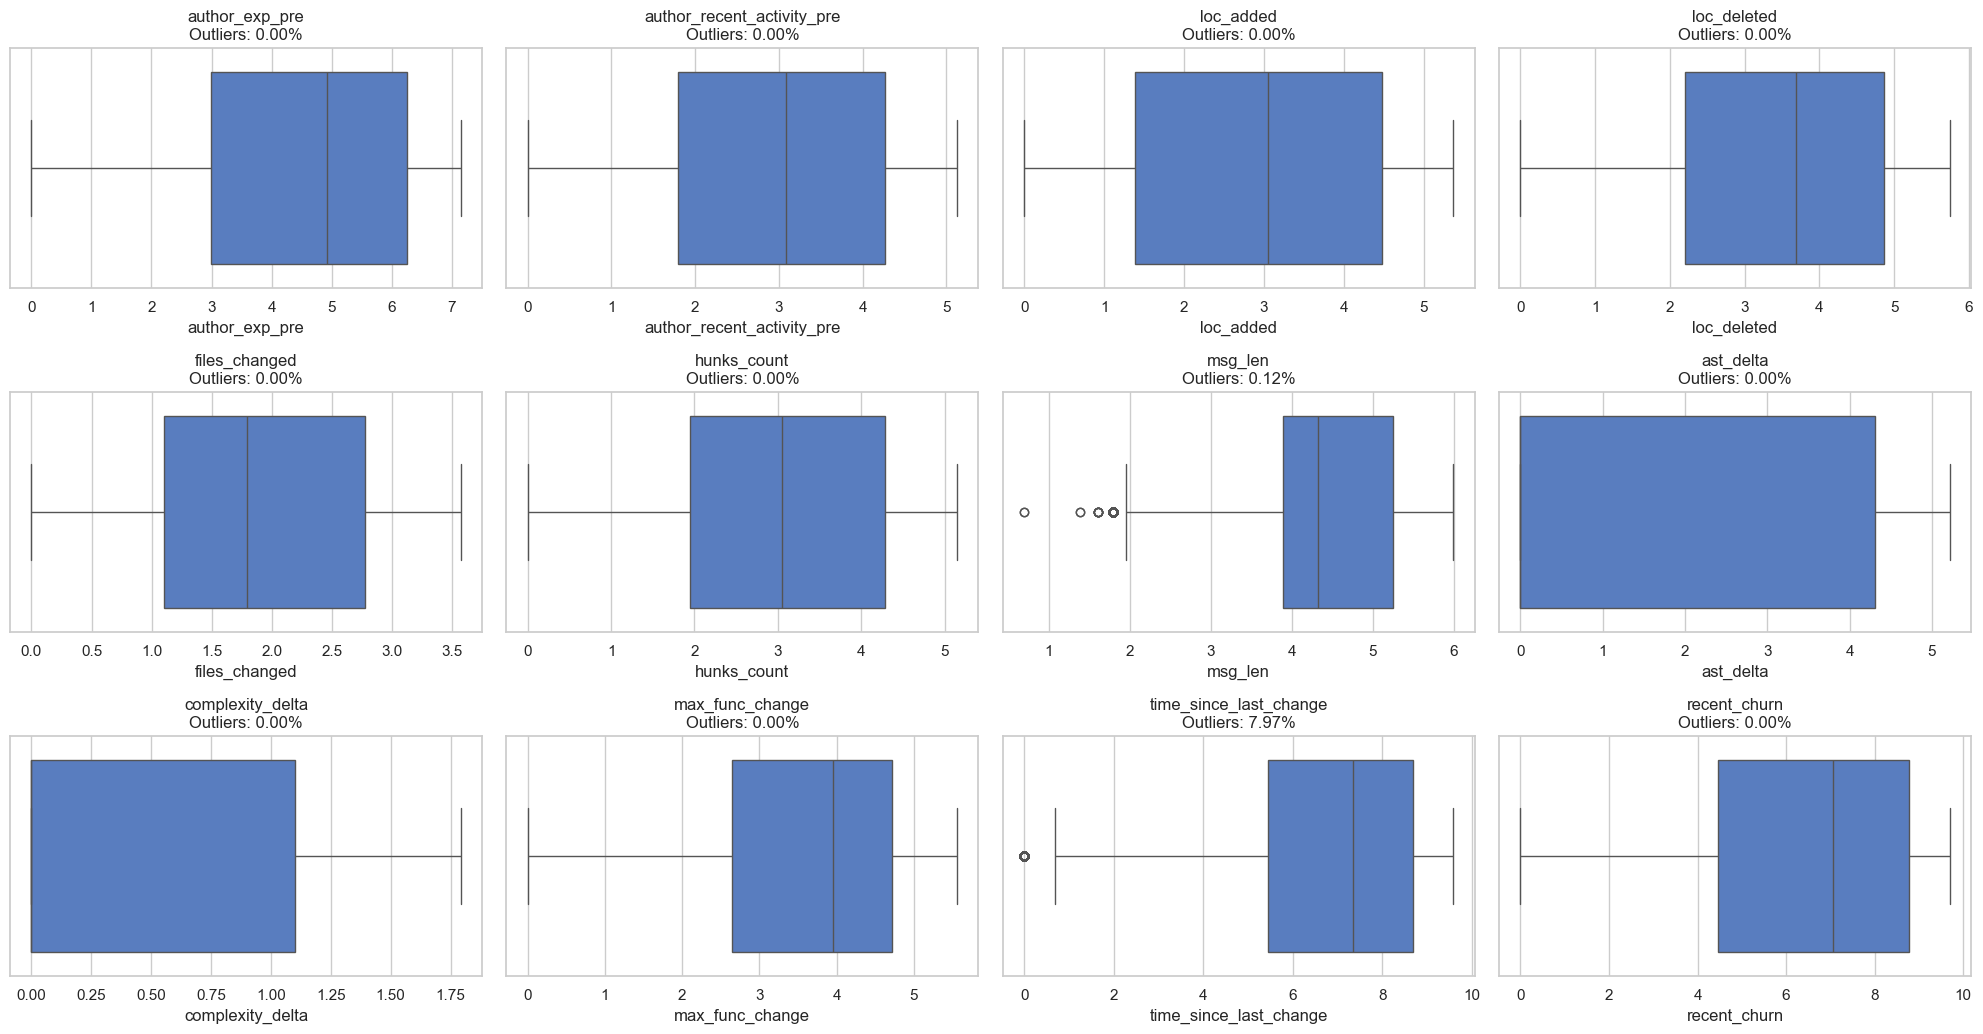

In [20]:

import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from constants import NUMERIC_FEATURES

def plot_boxplots_with_outliers(df, features, cols=4):
    log_check("Boxplot outlier analysis (feature, outlier%, bounds, mean, std, min, max)...")

    rows = math.ceil(len(features) / cols)
    plt.figure(figsize=(cols * 5, rows * 3.5))

    for i, feature in enumerate(features, 1):
        series = df[feature].dropna()

        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outlier_mask = (series < lower) | (series > upper)
        outlier_ratio = float(outlier_mask.mean())
        n_outliers = int(outlier_mask.sum())

        # Additional stats
        mean = float(series.mean())
        std = float(series.std())
        min_val = float(series.min())
        max_val = float(series.max())

        # ---- LOG ENTRY (1 line per feature) ----
        log_result(
            f"{feature}: outliers={outlier_ratio:.2%} ({n_outliers} rows), "
            f"bounds=({lower:.3f}, {upper:.3f}), "
            f"min={min_val:.3f}, max={max_val:.3f}, "
            f"mean={mean:.3f}, std={std:.3f}"
        )

        # ---- PLOT ----
        plt.subplot(rows, cols, i)
        sns.boxplot(x=series, linewidth=1)
        plt.title(f"{feature}\nOutliers: {outlier_ratio:.2%}")

    plt.tight_layout()
    plt.show()


# Call it
plot_boxplots_with_outliers(df, NUMERIC_FEATURES)

## 10. Code and Message Embeddings

Quick check of embedding norms and distribution

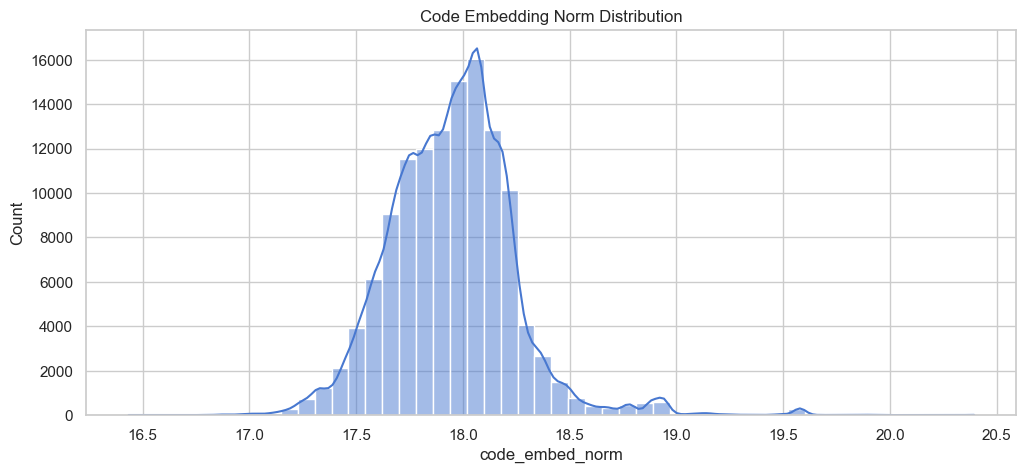

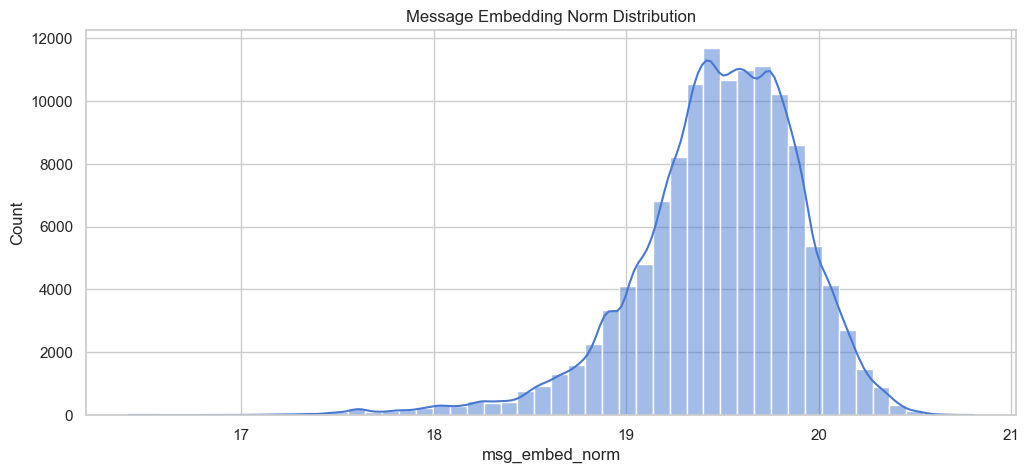

In [21]:
# %% 
log_check("Checking Embedding Norm Distributions (NAME, SKEW, KURT, MEAN, STD)...")

from scipy.stats import skew, kurtosis

df['code_embed_norm'] = df['code_embed'].apply(lambda x: np.linalg.norm(x))
df['msg_embed_norm'] = df['msg_embed'].apply(lambda x: np.linalg.norm(x))

plt.figure(figsize=(12,5))
sns.histplot(df['code_embed_norm'], bins=50, kde=True)
plt.title("Code Embedding Norm Distribution")
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(df['msg_embed_norm'], bins=50, kde=True)
plt.title("Message Embedding Norm Distribution")
plt.show()

for col in ["code_embed_norm", "msg_embed_norm"]:
    series = df[col].dropna()
    series_skew = skew(series)
    series_kurt = kurtosis(series)
    series_mean = series.mean()
    series_std = series.std()
    
    log_result(f"{col}: skew={series_skew:.3f}, kurt={series_kurt:.3f}, mean={series_mean:.3f}, std={series_std:.3f}")


## 11. Outlier & Negative `time_since_last_change` by Repo

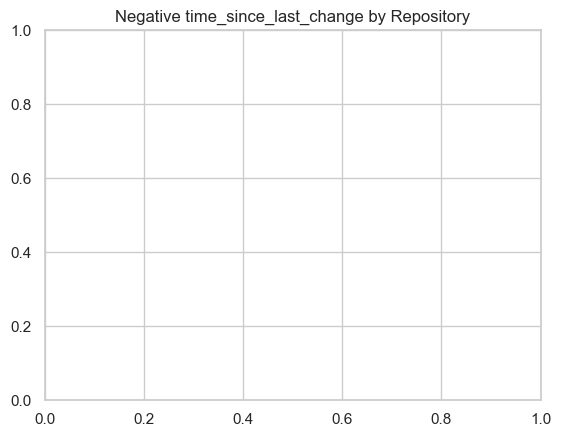

In [22]:
# %% 
log_check("Checking Negative time_since_last_change per Repository...")

# neg_times = df[df['time_since_last_change'] < 0]
# neg_times['repo'].value_counts()
neg_times = df[df['time_since_last_change'] < 0]
neg_repo_counts = neg_times['repo'].value_counts()
neg_repo_props = neg_repo_counts / len(df)

for repo in neg_repo_counts.index:
    count = neg_repo_counts[repo]
    prop = neg_repo_props[repo]
    log_result(f"{repo}: count={count}, proportion={prop:.3%}")
sns.countplot(x='repo', data=neg_times)
plt.title("Negative time_since_last_change by Repository")
plt.show()

Ansible has an extremely branch-heavy development model, with large numbers of parallel feature branches → this explains why Ansible dominates your negatives.

Because Ansible's development process is:

- highly distributed
- patch-based
- very branch-heavy
- contains large numbers of old branches merged late
- frequent external contributors with old author dates
- multiple maintainers commit patches on their behalf

This creates many opportunities for chronologically inconsistent commit sequences.

## 12. Feature Relationships with Label

Boxplots of numeric features by label

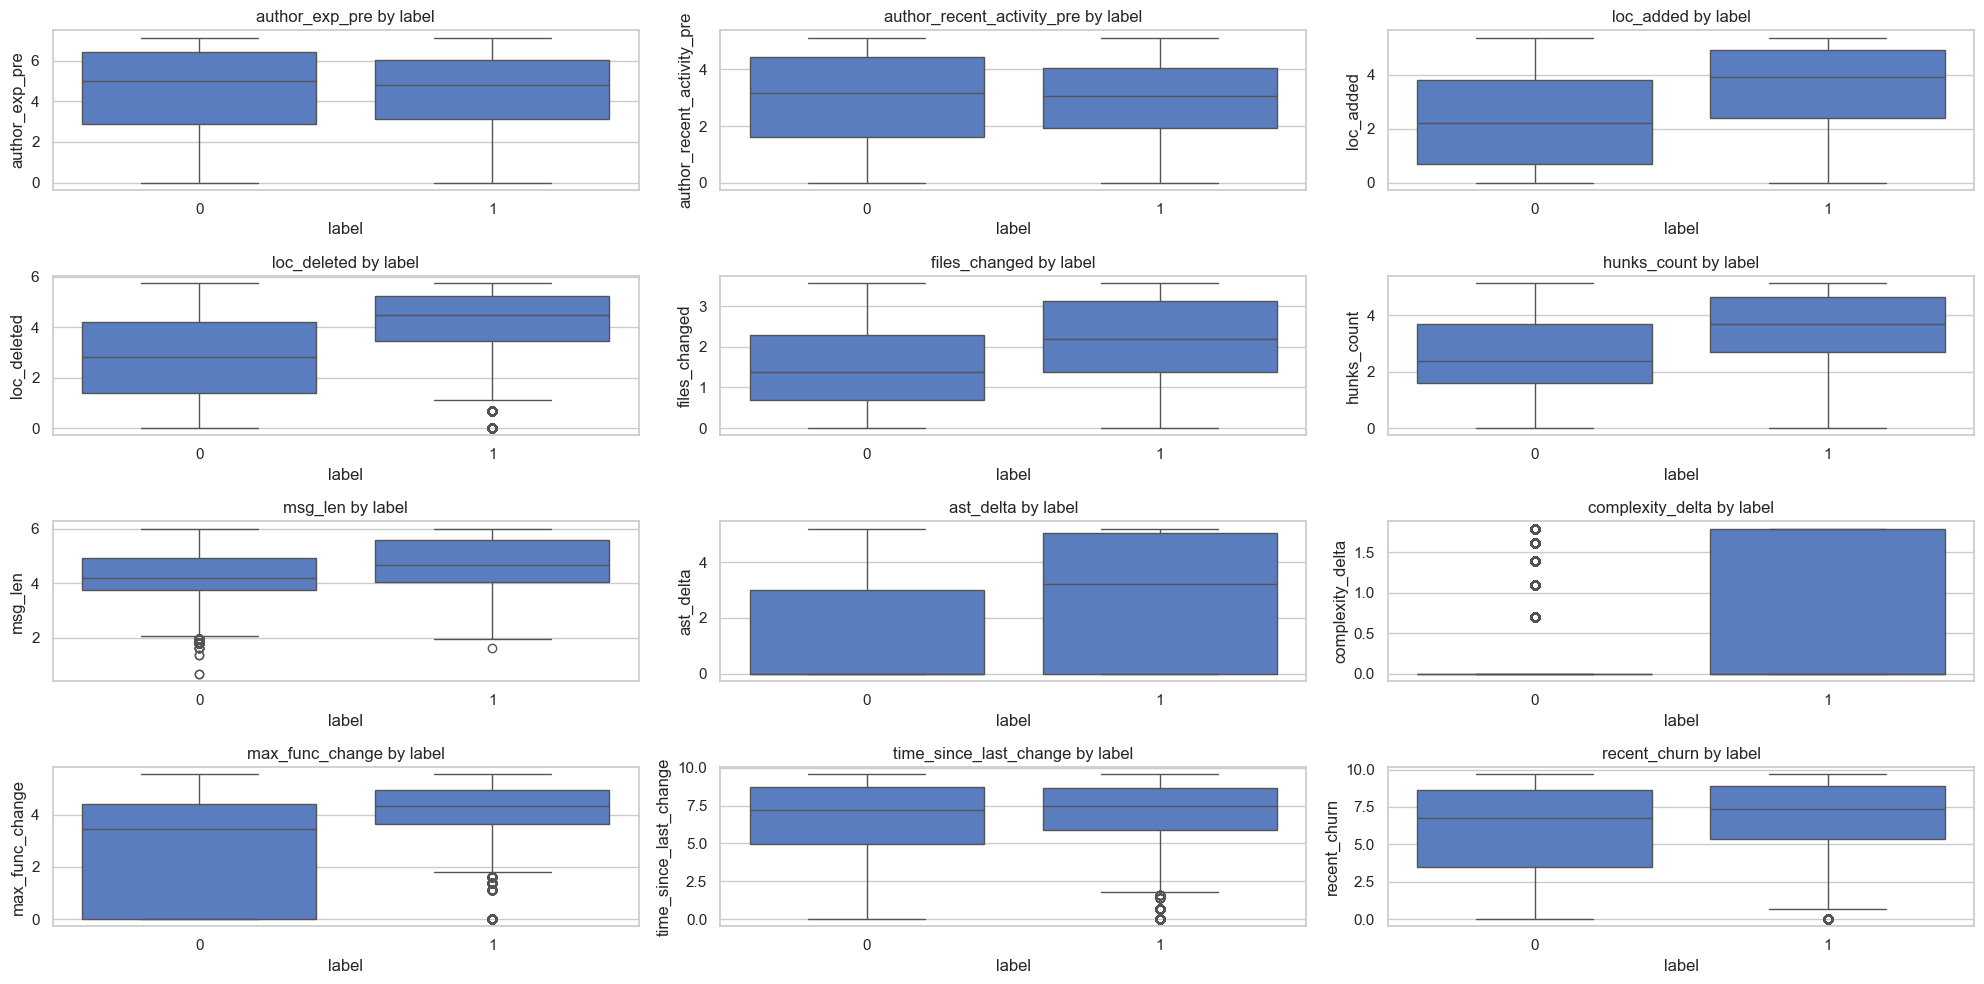

In [23]:
log_check("Checking Feature Distributions by Label... (median, IQR, min, max, outlier_ratio)")

# Logging metrics
for feature in NUMERIC_FEATURES:
    for lbl in df['label'].unique():
        series = df[df['label'] == lbl][feature].dropna()
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        median = series.median()
        min_val, max_val = series.min(), series.max()
        outlier_ratio = ((series < Q1 - 1.5*IQR) | (series > Q3 + 1.5*IQR)).mean()
        log_result(f"{feature} | label={lbl} | median={median:.2f}, IQR={IQR:.2f}, min={min_val:.2f}, max={max_val:.2f}, outlier_ratio={outlier_ratio:.2%}")

# Plotting
plt.figure(figsize=(20,10))
for i, col in enumerate(NUMERIC_FEATURES, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x='label', y=col, data=df)
    plt.title(f"{col} by label")

plt.tight_layout()
plt.show()

## 13. Keyword Features (todo, fixme, try/except/raise)

<Figure size 1500x500 with 0 Axes>

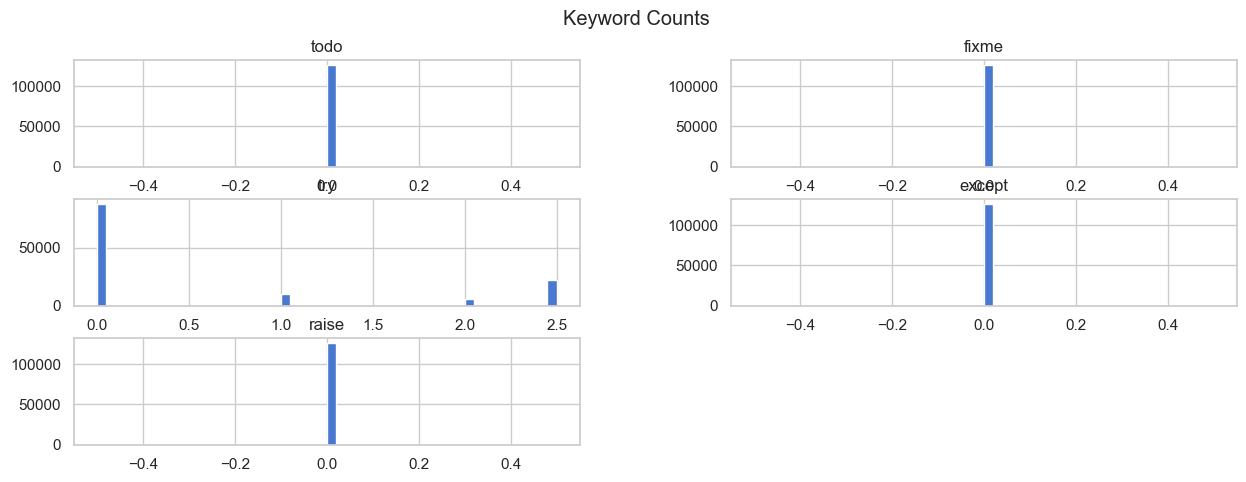

In [24]:
# %% 
log_check("Checking Keyword Count Distributions... (median, IQR, min, max, zero_ratio)")

from matplotlib import pyplot as plt


# kw_cols = ['todo','fixme','try','except','raise']
from notebooks.constants import LINE_TOKEN_FEATURES


plt.figure(figsize=(15,5))
df[LINE_TOKEN_FEATURES].hist(bins=50, figsize=(15,5))
plt.suptitle("Keyword Counts")
plt.show()

for feature in LINE_TOKEN_FEATURES:
    series = df[feature].dropna()
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    median = series.median()
    min_val, max_val = series.min(), series.max()
    zero_ratio = (series == 0).mean()
    
    log_result(
        f"{feature} | median={median:.2f}, IQR={IQR:.2f}, min={min_val}, max={max_val}, zero_ratio={zero_ratio:.2%}"
    )

## 14. Pairwise Relationships
 
Due to high cardinality, use only selected features

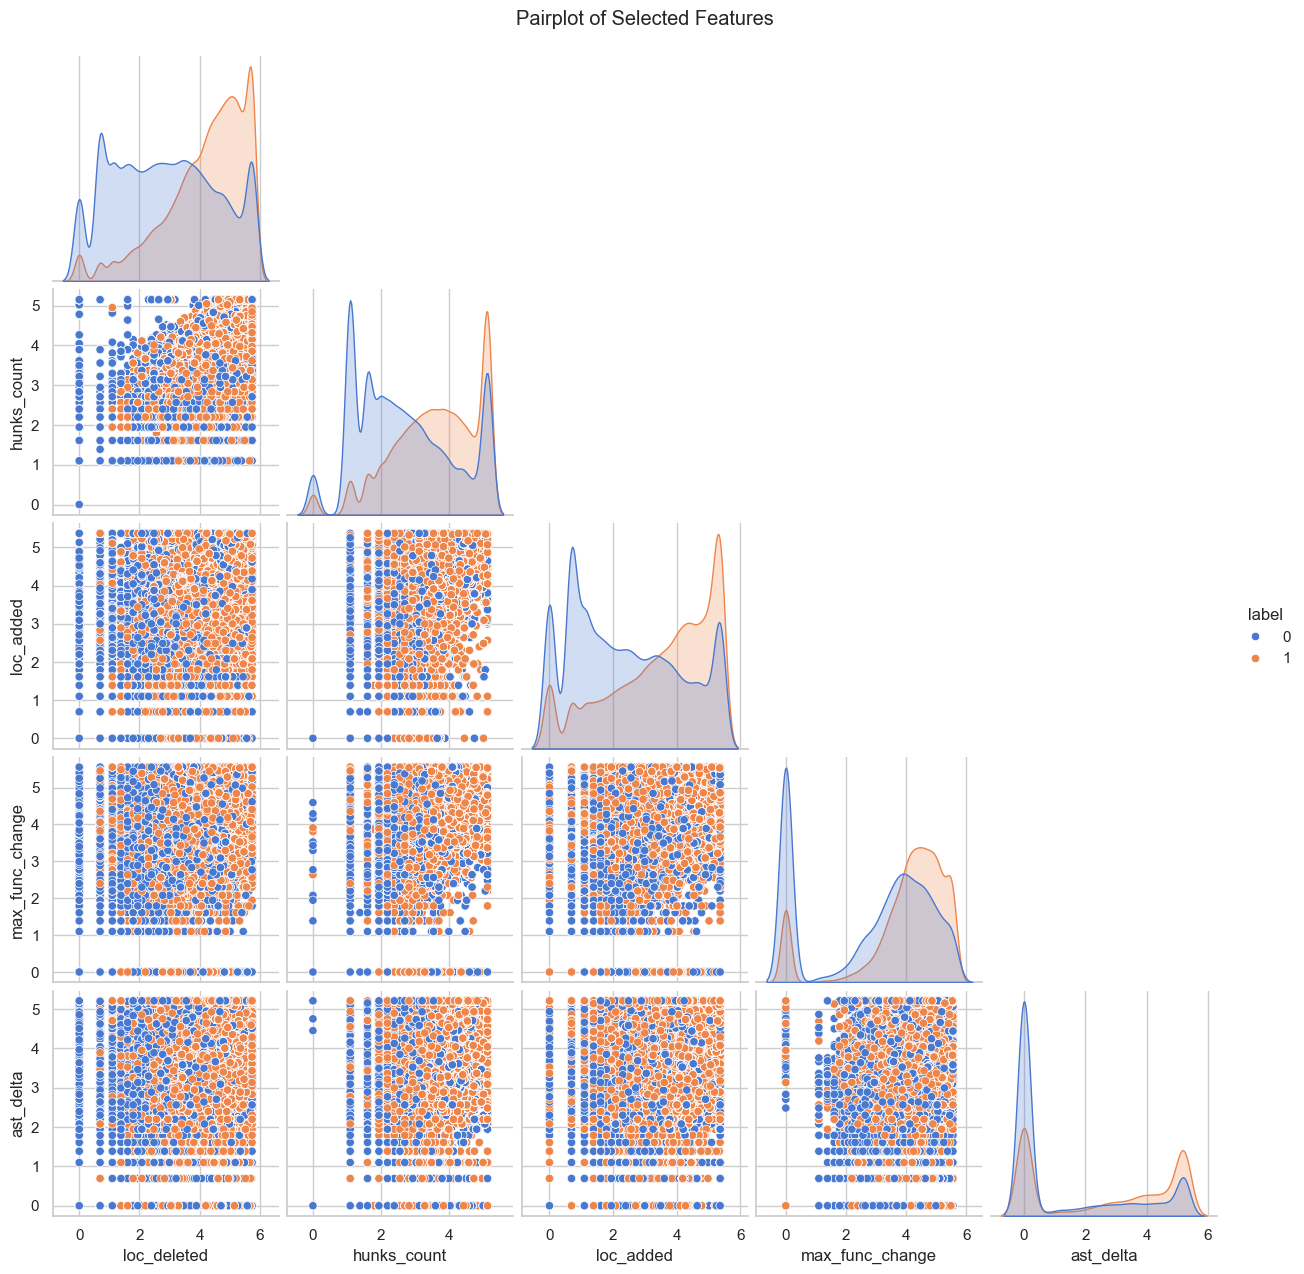

In [25]:
# %% 
TOP_FEATURES = 5

# Compute correlations with label
corr_with_label = df[num_cols + ['label']].corr()['label'].drop('label')  # exclude label itself

# Take top N correlated features
selected_features = corr_with_label.abs().sort_values(ascending=False).head(TOP_FEATURES).index.to_list()

# Add label back for hue
selected_features.append('label')

# print(selected_features)

# # selected_features = ['loc_added', 'loc_deleted', 'hunks_count', 'max_func_change', 'label']
# sns.pairplot(df[selected_features], hue='label', corner=True)
# plt.suptitle("Pairplot of Selected Features", y=1.02)
# plt.show()

# selected_features
log_check("Checking Selected Feature Distributions and Correlations... (median, IQR, min, max, overlap)")

# Exclude label for stats
features_only = selected_features[:-1]

# Log per-feature stats + overlap coefficient
for feature in features_only:
    series0 = df[df['label'] == 0][feature].dropna()
    series1 = df[df['label'] == 1][feature].dropna()

    # Basic stats on full feature
    median = df[feature].median()
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    min_val, max_val = df[feature].min(), df[feature].max()

    # Overlap between label groups
    bins = np.histogram_bin_edges(df[feature], bins='auto')
    hist0, _ = np.histogram(series0, bins=bins, density=True)
    hist1, _ = np.histogram(series1, bins=bins, density=True)
    overlap = np.sum(np.minimum(hist0, hist1)) * np.diff(bins)[0]

    log_result(
        f"{feature} | median={median:.2f}, IQR={IQR:.2f}, min={min_val:.2f}, max={max_val:.2f}, overlap={overlap:.2f}"
    )

# Log pairwise correlations among selected features (excluding label)
for i, feat1 in enumerate(features_only):
    for feat2 in features_only[i+1:]:
        corr_val = df[[feat1, feat2]].corr().iloc[0,1]
        log_result(f"Correlation {feat1} & {feat2}: {corr_val:.2f}")

# %%
# Pairplot for visualization
sns.pairplot(df[selected_features], hue='label', corner=True)
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()

### 15. Optional: t-SNE / PCA on Embeddings

Reduce embedding dimensions to 2D to visualize clustering by label

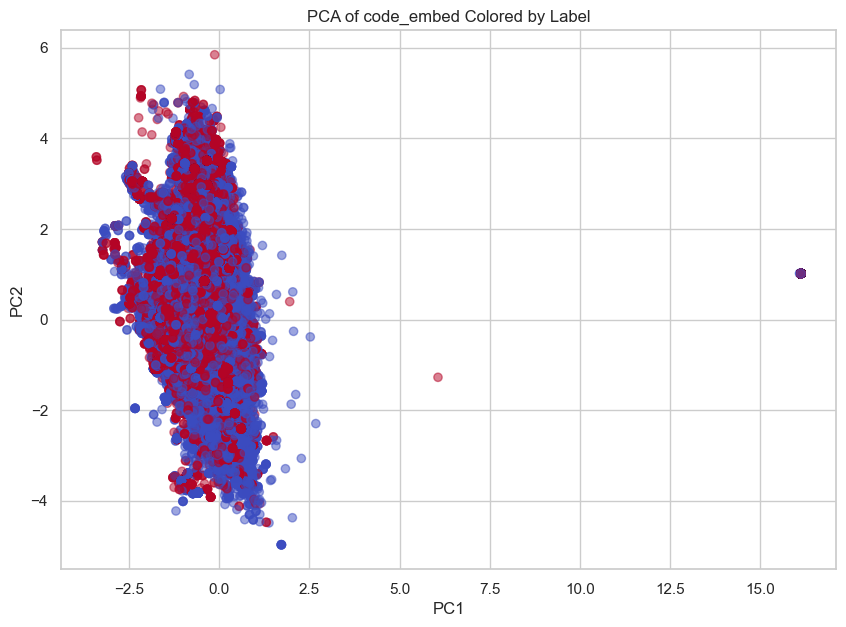

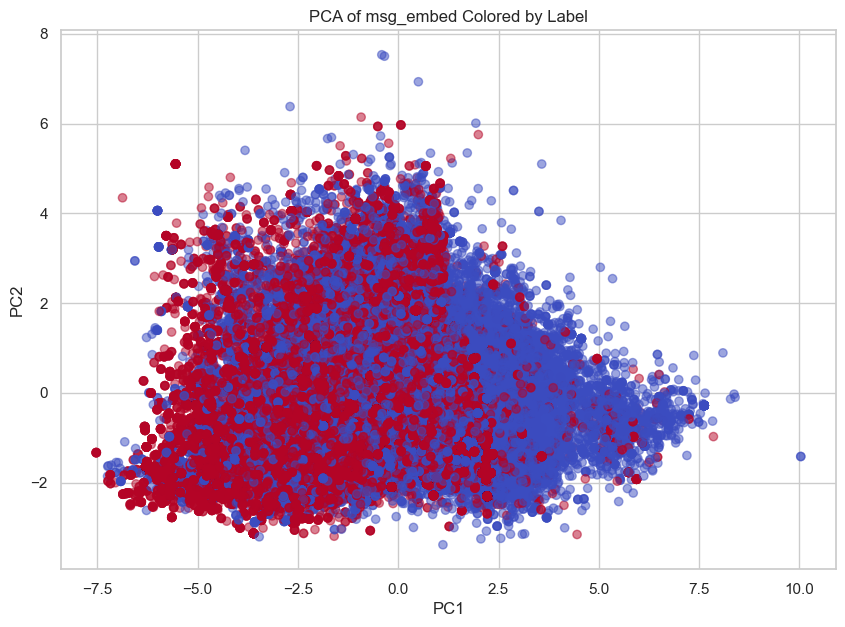

In [26]:
# # %% 
# from sklearn.decomposition import PCA
# from sklearn.metrics import pairwise_distances
# import matplotlib.pyplot as plt

# from constants import EMBEDDINGS

# pca_code = PCA(n_components=2)
# code_emb_2d = pca_code.fit_transform(np.vstack(df['code_embed'].values))

# # Variance explained
# var_explained = pca_code.explained_variance_ratio_
# log_check("PCA of code embeddings")
# log_result(f"Explained variance by PC1: {var_explained[0]:.2%}, PC2: {var_explained[1]:.2%}")

# # Compute mean distance between labels in 2D
# labels = df['label'].values
# points_label0 = code_emb_2d[labels == 0]
# points_label1 = code_emb_2d[labels == 1]

# sample_size = 2000  # or 2000 depending on your RAM

# points_label0_sample = points_label0[np.random.choice(points_label0.shape[0], sample_size, replace=False)]
# points_label1_sample = points_label1[np.random.choice(points_label1.shape[0], sample_size, replace=False)]

# inter_label_dist = pairwise_distances(points_label0_sample, points_label1_sample).mean()
# intra_dist_label0 = pairwise_distances(points_label0_sample).mean()
# intra_dist_label1 = pairwise_distances(points_label1_sample).mean()

# # Mean Euclidean distance between points of different labels
# # inter_label_dist = pairwise_distances(points_label0, points_label1).mean()
# log_result(f"Mean distance between label 0 and 1 in PCA 2D space: {inter_label_dist:.3f}")

# # Mean intra-label distances
# # intra_dist_label0 = pairwise_distances(points_label0).mean()
# # intra_dist_label1 = pairwise_distances(points_label1).mean()
# log_result(f"Mean intra-label distances - label 0: {intra_dist_label0:.3f}, label 1: {intra_dist_label1:.3f}")

# plt.figure(figsize=(10,7))
# plt.scatter(code_emb_2d[:,0], code_emb_2d[:,1], c=df['label'], cmap='coolwarm', alpha=0.5)
# plt.title("PCA of Code Embeddings Colored by Label")
# plt.xlabel("PC1")
# plt.ylabel("PC2")
# plt.show()
# %% 
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import numpy as np

from constants import EMBEDDINGS

sample_size = 2000  # safe for memory

for emb_name in EMBEDDINGS:
    log_check(f"PCA of {emb_name}")

    # Stack embeddings into 2D array
    emb_matrix = np.vstack(df[emb_name].values)

    # PCA to 2D
    pca = PCA(n_components=2)
    emb_2d = pca.fit_transform(emb_matrix)

    # Explained variance
    var_explained = pca.explained_variance_ratio_
    log_result(f"{emb_name} - Explained variance by PC1: {var_explained[0]:.2%}, PC2: {var_explained[1]:.2%}")

    # Split by labels
    labels = df['label'].values
    points_label0 = emb_2d[labels == 0]
    points_label1 = emb_2d[labels == 1]

    # Sampling to avoid memory issues
    points_label0_sample = points_label0[np.random.choice(points_label0.shape[0], min(sample_size, points_label0.shape[0]), replace=False)]
    points_label1_sample = points_label1[np.random.choice(points_label1.shape[0], min(sample_size, points_label1.shape[0]), replace=False)]

    # Distances
    inter_label_dist = pairwise_distances(points_label0_sample, points_label1_sample).mean()
    intra_dist_label0 = pairwise_distances(points_label0_sample).mean()
    intra_dist_label1 = pairwise_distances(points_label1_sample).mean()

    log_result(f"{emb_name} - Mean distance between label 0 and 1 in PCA 2D space: {inter_label_dist:.3f}")
    log_result(f"{emb_name} - Mean intra-label distances: label 0: {intra_dist_label0:.3f}, label 1: {intra_dist_label1:.3f}")

    # Plot
    plt.figure(figsize=(10,7))
    plt.scatter(emb_2d[:,0], emb_2d[:,1], c=df['label'], cmap='coolwarm', alpha=0.5)
    plt.title(f"PCA of {emb_name} Colored by Label")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

#### Interpretation:

- If points of different labels cluster separately → the embeddings capture some discriminative information for predicting bugs.
- If points overlap heavily → embeddings might not strongly differentiate buggy vs. non-buggy commits.
- You can also get an idea of outliers or general spread of the embeddings.

This visualization helps you explore how informative the embeddings are for your target labels in 2D space.